# 2 Data wrangling

# 1. Project Overview

### 1.1  Problem Statement <a id='2.2.1_Problem'></a>

The goal of this project is creating a model that predicts the length-of-stay for each patient at time of admission and also identify factors are associated with length of hospital stay, based on health records, in order to manage hospital stay more efficiently.

## 2. Imports<a id='2.3_Imports'></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import pearsonr
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
import os

## 3. Load The Data<a id='2.5_Load_The_Load_Length_Of_Stay_Data'></a>

In [2]:
#df = pd.read_csv('mimic-iii-clinical-database-demo-1.4/Hospital_Inpatient_Discharges__SPARCS_De-Identified___2015.csv')

In [3]:
#ADMISSIONS.csv, PATIENTS.csv, DIAGNOSES_ICD.csv, and ICUSTAYS.csv.
df  = pd.read_csv("mimic-iii-clinical-database-demo-1.4/ADMISSIONS.csv")
df_pat= pd.read_csv('mimic-iii-clinical-database-demo-1.4/PATIENTS.csv')
df_diagcode=pd.read_csv('mimic-iii-clinical-database-demo-1.4/DIAGNOSES_ICD.csv')
df_icu=pd.read_csv('mimic-iii-clinical-database-demo-1.4/ICUSTAYS.csv')


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   row_id                129 non-null    int64 
 1   subject_id            129 non-null    int64 
 2   hadm_id               129 non-null    int64 
 3   admittime             129 non-null    object
 4   dischtime             129 non-null    object
 5   deathtime             40 non-null     object
 6   admission_type        129 non-null    object
 7   admission_location    129 non-null    object
 8   discharge_location    129 non-null    object
 9   insurance             129 non-null    object
 10  language              81 non-null     object
 11  religion              128 non-null    object
 12  marital_status        113 non-null    object
 13  ethnicity             129 non-null    object
 14  edregtime             92 non-null     object
 15  edouttime             92 non-null     ob

lengthofstay is the colom we are looking for

In [7]:
print('Dataset has {} number of unique admission events.'.format(df['hadm_id'].nunique()))
print('Dataset has {} number of unique patients.'.format(df['subject_id'].nunique()))

Dataset has 129 number of unique admission events.
Dataset has 100 number of unique patients.


In [8]:
df.head()

,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data
0,12258,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,SEPARATED,BLACK/AFRICAN AMERICAN,2164-10-23 16:43:00,2164-10-23 23:00:00,SEPSIS,0,1
1,12263,10011,105331,2126-08-14 22:32:00,2126-08-28 18:59:00,2126-08-28 18:59:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Private,NaN,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,NaN,NaN,HEPATITIS B,1,1
2,12265,10013,165520,2125-10-04 23:36:00,2125-10-07 15:13:00,2125-10-07 15:13:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,NaN,UNKNOWN/NOT SPECIFIED,NaN,NaN,SEPSIS,1,1
3,12269,10017,199207,2149-05-26 17:19:00,2149-06-03 18:42:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,CATHOLIC,DIVORCED,WHITE,2149-05-26 12:08:00,2149-05-26 19:45:00,HUMERAL FRACTURE,0,1
4,12270,10019,177759,2163-05-14 20:43:00,2163-05-15 12:00:00,2163-05-15 12:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,DIVORCED,WHITE,NaN,NaN,ALCOHOLIC HEPATITIS,1,1


In [12]:
# convert admission and discharge times to datatime type
df['admittime'] = pd.to_datetime(df['admittime'])
df['dischtime'] = pd.to_datetime(df['dischtime'])

# convert timedelta type into float 'days', 86400 seconds in a day
df['LOS'] = (df['dischtime'] - df['admittime']).dt.total_seconds()/86400

In [13]:
# verify
df[['admittime', 'dischtime', 'LOS']].head()

,admittime,dischtime,LOS
0,2164-10-23 21:09:00,2164-11-01 17:15:00,8.837500
1,2126-08-14 22:32:00,2126-08-28 18:59:00,13.852083
2,2125-10-04 23:36:00,2125-10-07 15:13:00,2.650694
3,2149-05-26 17:19:00,2149-06-03 18:42:00,8.057639
4,2163-05-14 20:43:00,2163-05-15 12:00:00,0.636806


In [14]:
df['LOS'].describe()

count    129.000000
mean       9.332332
std       12.720450
min        0.038194
25%        3.314583
50%        6.634028
75%       10.645139
max      123.984722
Name: LOS, dtype: float64

In [15]:
# Look at what is happening with negative LOS values
df[df['LOS'] < 0]

,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,...,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data,los,LOS


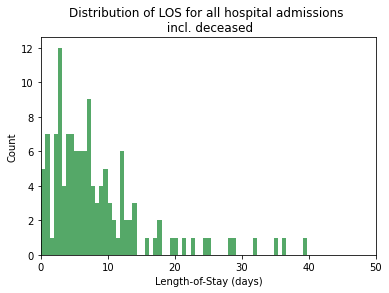

In [16]:
# Plot LOS Distribution
plt.hist(df['LOS'], bins=200, color = '#55a868')
plt.xlim(0, 50)
plt.title('Distribution of LOS for all hospital admissions \n incl. deceased')
plt.ylabel('Count')
plt.xlabel('Length-of-Stay (days)')
plt.tick_params(top=False, right=False) 
plt.show();

In [19]:
# pre-emptively drop some columns that i don't need anymore
df.drop(columns=['dischtime', 'row_id', 
                'edregtime', 'edouttime', 'hospital_expire_flag',
                'has_chartevents_data'], inplace=True)

In [22]:
# mark admissions where patients died in boolean column
df['deceased'] = df['deathtime'].notnull().map({True:1, False:0})

In [23]:
print("{} of {} patients died in the hospital".format(df['deceased'].sum(), 
                                                     df['subject_id'].nunique()))

40 of 100 patients died in the hospital


In [24]:
# look at statistics less admissions resulting in death
df['los'].loc[df['deceased'] == 0].describe()

count     89.000000
mean       9.766526
std       13.934030
min        0.980556
25%        4.104167
50%        6.830556
75%       10.146528
max      123.984722
Name: los, dtype: float64

In [26]:
# hospital los metrics for later comparison
actual_mean_los = df['LOS'].loc[df['deceased'] == 0].mean() 
actual_median_los = df['LOS'].loc[df['deceased'] == 0].median() 

print(actual_mean_los)
print(actual_median_los)

9.766526217228463
6.830555555555556
